# **Importing all necessary libraries and creating an enviroment for data plots and outputs.**

In [ ]:
import os
import requests
import re
from datetime import datetime
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from waybackpy import WaybackMachineCDXServerAPI
from urllib.parse import urlparse
warnings.filterwarnings('ignore')
directories = ['data', 'data/raw', 'data/processed', 'plots', 'output']
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")

print("Environment setup complete!")


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Created directory: data
Created directory: data/raw
Created directory: data/processed
Created directory: plots
Created directory: output
Environment setup complete!


# **Testing 1 URL if it retrives snapshots**

In [ ]:
group_a = [
    "https://time.com/robots.txt",
    "https://www.spiegel.de/robots.txt",
    "https://fortune.com/robots.txt",
    "https://www.entrepreneur.com/robots.txt",
    "https://www.latimes.com/robots.txt",
    "https://www.independent.co.uk/robots.txt",
    "https://www.adweek.com/robots.txt",
    "https://www.blavity.com/robots.txt",
    "https://www.prisa.com/robots.txt",
    "https://www.rtl.de/robots.txt"
]

group_b = [
    "https://www.nytimes.com/robots.txt",
    "https://www.wsj.com/robots.txt",
    "https://www.washingtonpost.com/robots.txt",
    "https://www.bbc.com/robots.txt",
    "https://www.theguardian.com/robots.txt",
    "https://www.bloomberg.com/robots.txt",
    "https://www.businessinsider.com/robots.txt",
    "https://www.vox.com/robots.txt",
    "https://www.wired.com/robots.txt",
    "https://www.forbes.com/robots.txt"
]

all_urls = group_a + group_b
url_groups = {url: 'Group A' if url in group_a else 'Group B' for url in all_urls}

print(f"Total number of URLs to process: {len(all_urls)}")
print(f"Group A: {len(group_a)} URLs")
print(f"Group B: {len(group_b)} URLs")

#Creating improved functions to fetch historical robots.txt data
def get_snapshots(url, start_date="20230601", end_date="20250331", user_agent="Mozilla/5.0"):
    """
    Get all available snapshots for a URL within a date range using Wayback Machine.
    
    Args:
        url: The URL to get snapshots for
        start_date: Start date in YYYYMMDD format
        end_date: End date in YYYYMMDD format
        user_agent: User agent string for the request
        
    Returns:
        List of snapshot objects
    """
    try:
        cdx_api = WaybackMachineCDXServerAPI(
            url=url,
            user_agent=user_agent,
            start_timestamp=start_date,
            end_timestamp=end_date
        )
        
        # Get all snapshots for the URL
        snapshots = list(cdx_api.snapshots())
        return snapshots
    except Exception as e:
        print(f"Error getting snapshots for {url}: {str(e)}")
        return []

def fetch_robots_txt_content(snapshot, original_url):
    """
    Fetch the content of a robots.txt file from a specific Wayback Machine snapshot.
    
    Args:
        snapshot: A snapshot object from WaybackMachineCDXServerAPI
        original_url: The original URL the snapshot is for
        
    Returns:
        Dict containing URL, timestamp, and robots.txt content
    """
    try:
        # Get the archived URL
        archive_url = snapshot.archive_url
        
        # Fetch the content
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(archive_url, headers=headers, timeout=10)
        
        if response.status_code == 200:
            return {
                'url': original_url,
                'base_url': urlparse(original_url).netloc,
                'timestamp': snapshot.timestamp,
                'archive_url': archive_url,
                'content': response.text,
                'status': 'success'
            }
        else:
            return {
                'url': original_url,
                'base_url': urlparse(original_url).netloc,
                'timestamp': snapshot.timestamp,
                'archive_url': archive_url,
                'content': None,
                'status': f'HTTP Error: {response.status_code}'
            }
    except Exception as e:
        return {
            'url': original_url,
            'base_url': urlparse(original_url).netloc,
            'timestamp': snapshot.timestamp if hasattr(snapshot, 'timestamp') else None,
            'archive_url': archive_url if 'archive_url' in locals() else None,
            'content': None,
            'status': f'Error: {str(e)}'
        }
test_url = all_urls[0]
print(f"\nTesting snapshot retrieval for {test_url}")
test_snapshots = get_snapshots(test_url)
print(f"Found {len(test_snapshots)} snapshots for {test_url}")

if test_snapshots:
    first_snapshot = test_snapshots[0]
    print(f"Testing content retrieval for snapshot from: {first_snapshot.timestamp}")
    result = fetch_robots_txt_content(first_snapshot, test_url)
    print(f"Status: {result['status']}")
    
    if result['content']:
        print("Content sample (first 200 characters):")
        print(result['content'][:200] + "...")
else:
    print("No snapshots found for testing.")

Total number of URLs to process: 20
Group A: 10 URLs
Group B: 10 URLs

Testing snapshot retrieval for https://time.com/robots.txt
Found 55414 snapshots for https://time.com/robots.txt
Testing content retrieval for snapshot from: 20230601000111
Status: success
Content sample (first 200 characters):
Sitemap: https://time.com/news-sitemap.xml

User-agent: *
Disallow: /wp-admin/
Allow: /wp-admin/admin-ajax.php
# exclude urls of format time.com/page/7456/?search
User-agent: Googlebot
Disallow: /?sea...


# **Processing URLS in 5 batches to save progress if it loses connection**

In [ ]:
def collect_all_publishers_data(url_list, start_date="20230601", end_date="20250331", batch_size=5):
    """
    Collect data for all publishers with incremental saving.
    
    Args:
        url_list: List of URLs to collect snapshots for
        start_date: Start date in YYYYMMDD format
        end_date: End date in YYYYMMDD format
        batch_size: Number of URLs to process before saving progress
        
    Returns:
        DataFrame with all collected data
    """
    all_data = []
    
    # Processed URLs in batches
    for i in range(0, len(url_list), batch_size):
        batch = url_list[i:i+batch_size]
        print(f"\nProcessing batch {i//batch_size + 1}/{(len(url_list) + batch_size - 1)//batch_size}: URLs {i+1}-{min(i+batch_size, len(url_list))}")
        
        # Collecting data for this batch
        batch_data = collect_monthly_snapshots_alt(batch, start_date, end_date)
        all_data.extend(batch_data)
        
        # Saving progress after each batch
        df = pd.DataFrame(all_data)
        df.to_csv(f'data/raw/robots_data_progress_{i+batch_size}.csv', index=False)
        print(f"Saved progress: {len(all_data)} snapshots collected so far")
        
        # saving to the final output file
        df.to_csv('data/raw/robots_data_complete.csv', index=False)
    
    return pd.DataFrame(all_data)
print("Starting collection for all publishers")
full_data = collect_all_publishers_data(all_urls)

# Saving final dataset
full_data.to_csv('data/raw/robots_data_final.csv', index=False)
print(f"Data collection complete. Collected {len(full_data)} snapshots in total.")
print(full_data.groupby(['base_url', 'group']).count()[['timestamp']].reset_index().head(20))

Starting collection for all publishers

Processing batch 1/4: URLs 1-5
Processing 1/5: https://time.com/robots.txt
  Fetching 2023-06 from https://web.archive.org/web/20230601000000/https://time.com/robots.txt
  Error for 2023-06: HTTPSConnectionPool(host='web.archive.org', port=443): Read timed out. (read timeout=15)
  Fetching 2023-07 from https://web.archive.org/web/20230701000000/https://time.com/robots.txt
  Error for 2023-07: HTTPSConnectionPool(host='web.archive.org', port=443): Read timed out. (read timeout=15)
  Fetching 2023-08 from https://web.archive.org/web/20230801000000/https://time.com/robots.txt
  Error for 2023-08: HTTPSConnectionPool(host='web.archive.org', port=443): Read timed out. (read timeout=15)
  Fetching 2023-09 from https://web.archive.org/web/20230901000000/https://time.com/robots.txt
  Error for 2023-09: HTTPSConnectionPool(host='web.archive.org', port=443): Read timed out. (read timeout=15)
  Fetching 2023-10 from https://web.archive.org/web/2023100100000

# **Cleaned the dataset for empty feilds with NA and saving to a new csv file**

In [ ]:
import pandas as pd
df = pd.read_csv('robots_data_final.csv')
df['content'].replace('', pd.NA, inplace=True)
df.to_csv('robots_data_cleaned.csv', index=False)

print("File saved as robots_data_cleaned.csv")


File saved as robots_data_cleaned.csv


/var/folders/p1/2ml0fv9x7x79s1nnddt1_10h0000gn/T/ipykernel_2103/587330732.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['content'].replace('', pd.NA, inplace=True)


# **Filters to see only successful retrival of snapshots**

In [ ]:
import pandas as pd
data = pd.read_csv('robots_data_cleaned.csv')

successful_data = data[data['status'] == 'success']
successful_data.head()


,url,base_url,timestamp,formatted_date,archive_url,content,status,group
9,https://time.com/robots.txt,time.com,20240301000835,2024-03-01,https://web.archive.org/web/20240301000835/htt...,User-Agent: *\nAllow: /wp-admin/admin-ajax.php...,success,Group A
11,https://time.com/robots.txt,time.com,20240430235059,2024-04-30,https://web.archive.org/web/20240430235059/htt...,User-Agent: *\nAllow: /wp-admin/admin-ajax.php...,success,Group A
12,https://time.com/robots.txt,time.com,20240601000029,2024-06-01,https://web.archive.org/web/20240601000029/htt...,User-Agent: *\nAllow: /wp-admin/admin-ajax.php...,success,Group A
13,https://time.com/robots.txt,time.com,20240701002331,2024-07-01,https://web.archive.org/web/20240701002331/htt...,User-Agent: *\nAllow: /wp-admin/admin-ajax.php...,success,Group A
16,https://time.com/robots.txt,time.com,20241001001507,2024-10-01,https://web.archive.org/web/20241001001507/htt...,User-Agent: *\nAllow: /wp-admin/admin-ajax.php...,success,Group A


# **Checking the list of AI crawlers retrieved.**

In [ ]:
import re
crawlers = ['GPTBot', 'ChatGPT-User', 'OAI-SearchBot', 'Google-Extended', 'PerplexityBot', 'anthropic-ai', 'ClaudeBot', 'Claude-Web']

# Extracting crawlers from the content column
def extract_crawlers(content):
    found_crawlers = []
    content = str(content).lower()  # made content lowercase to handle case insensitivity
    for crawler in crawlers:
        if re.search(crawler.lower(), content):  # case-insensitive search
            found_crawlers.append(crawler)
    return found_crawlers if found_crawlers else None  # return None if no crawlers found
successful_data['crawlers'] = successful_data['content'].apply(extract_crawlers)

successful_data[['url', 'crawlers']].head(30)


/var/folders/p1/2ml0fv9x7x79s1nnddt1_10h0000gn/T/ipykernel_2103/1823909470.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_data['crawlers'] = successful_data['content'].apply(extract_crawlers)


,url,crawlers
9,https://time.com/robots.txt,[GPTBot]
11,https://time.com/robots.txt,[GPTBot]
12,https://time.com/robots.txt,[GPTBot]
13,https://time.com/robots.txt,[GPTBot]
16,https://time.com/robots.txt,[GPTBot]
17,https://time.com/robots.txt,None
19,https://time.com/robots.txt,None
21,https://time.com/robots.txt,None
26,https://www.spiegel.de/robots.txt,[GPTBot]
27,https://www.spiegel.de/robots.txt,"[GPTBot, Google-Extended]"


# **Data Processing: Flattening Crawlers and Counting Occurrences Over Time**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
successful_data['timestamp'] = pd.to_datetime(successful_data['timestamp'], format='%Y%m%d%H%M%S')
crawler_trends = successful_data.explode('crawlers')
crawler_count_by_time = crawler_trends.groupby([crawler_trends['timestamp'].dt.to_period('M'), 'crawlers']).size().reset_index(name='count')
crawler_count_by_time['timestamp'] = crawler_count_by_time['timestamp'].dt.to_timestamp()
crawler_count_by_time.head(30)


/var/folders/p1/2ml0fv9x7x79s1nnddt1_10h0000gn/T/ipykernel_2103/2412184370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_data['timestamp'] = pd.to_datetime(successful_data['timestamp'], format='%Y%m%d%H%M%S')


,timestamp,crawlers,count
0,2023-08-01,ChatGPT-User,2
1,2023-08-01,GPTBot,4
2,2023-09-01,GPTBot,1
3,2023-10-01,ChatGPT-User,3
4,2023-10-01,GPTBot,7
5,2023-10-01,Google-Extended,1
6,2023-10-01,anthropic-ai,1
7,2023-11-01,ChatGPT-User,2
8,2023-11-01,GPTBot,7
9,2023-11-01,Google-Extended,3


# **Time-series data for crawler trends**

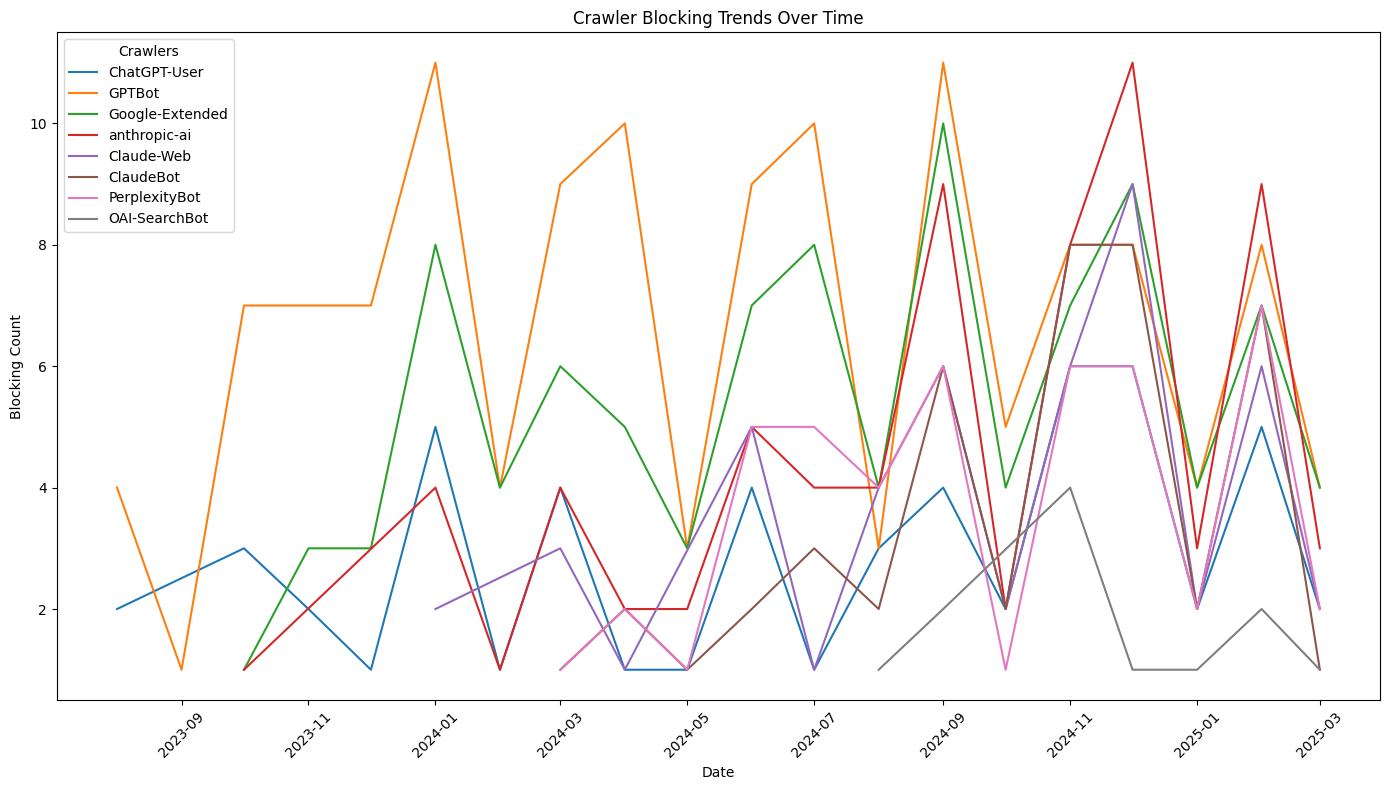

In [ ]:
plt.figure(figsize=(14, 8))

for crawler in crawler_count_by_time['crawlers'].unique():
    data = crawler_count_by_time[crawler_count_by_time['crawlers'] == crawler]
    plt.plot(data['timestamp'], data['count'], label=crawler)

plt.title('Crawler Blocking Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Blocking Count')
plt.legend(title='Crawlers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Grouping by timestamp**

In [ ]:
crawler_trends = successful_data.explode('crawlers')
crawler_count_by_time = crawler_trends.groupby([crawler_trends['timestamp'].dt.to_period('M'), 'crawlers', 'group']).size().reset_index(name='count')

crawler_count_by_time['timestamp'] = crawler_count_by_time['timestamp'].dt.to_timestamp()
crawler_count_by_time.head(20)


,timestamp,crawlers,group,count
0,2023-08-01,ChatGPT-User,Group A,1
1,2023-08-01,ChatGPT-User,Group B,1
2,2023-08-01,GPTBot,Group A,2
3,2023-08-01,GPTBot,Group B,2
4,2023-09-01,GPTBot,Group A,1
5,2023-10-01,ChatGPT-User,Group A,1
6,2023-10-01,ChatGPT-User,Group B,2
7,2023-10-01,GPTBot,Group A,2
8,2023-10-01,GPTBot,Group B,5
9,2023-10-01,Google-Extended,Group B,1


# **Comparative analysis of crawlers blocked by group A and group B by dates.**

/var/folders/p1/2ml0fv9x7x79s1nnddt1_10h0000gn/T/ipykernel_2103/3339764399.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=crawler_count_by_time, x='timestamp', y='count', hue='group', ci=None)


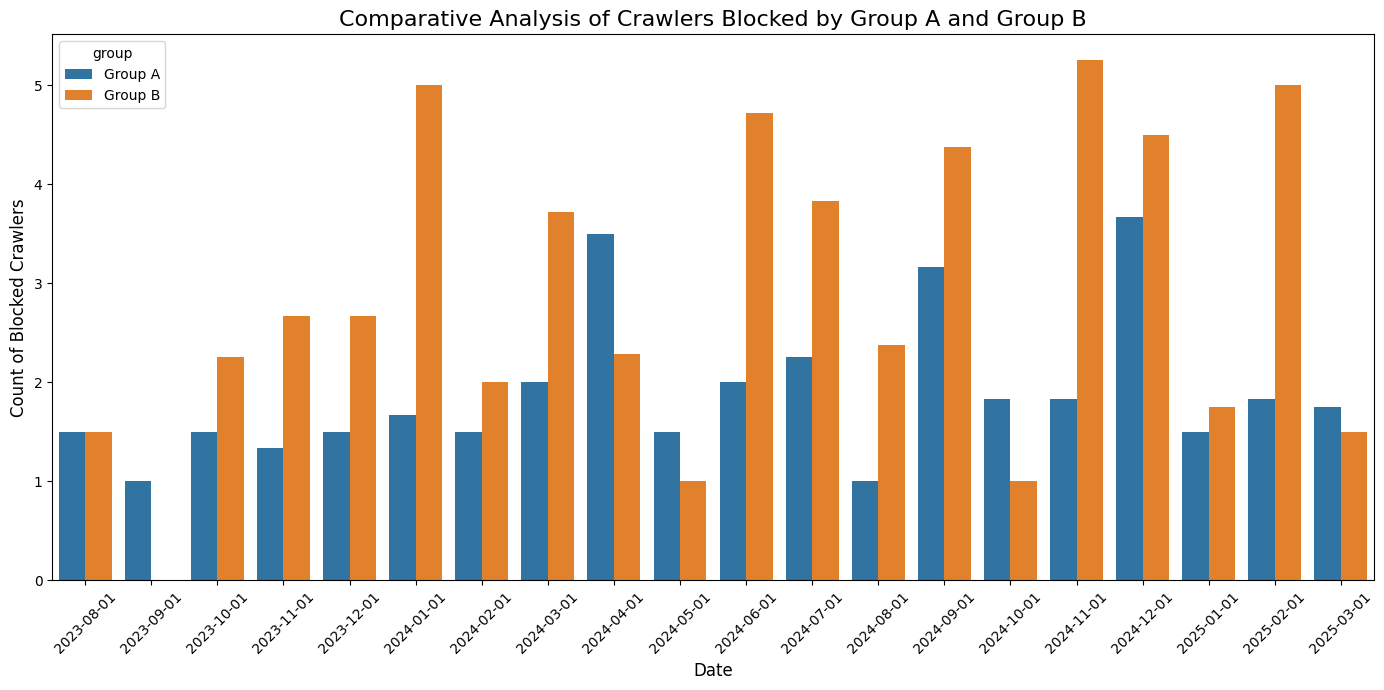

In [8]:
import seaborn as sns
# Create a bar plot for comparative analysis between Group A and Group B
plt.figure(figsize=(14, 7))

# Plot the trends for each group
sns.barplot(data=crawler_count_by_time, x='timestamp', y='count', hue='group', ci=None)

# Set plot labels and title
plt.title('Comparative Analysis of Crawlers Blocked by Group A and Group B', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count of Blocked Crawlers', fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()
